# Applied Machine Learning Midterm Project: _Classification Analysis_

## Jason Ballard

#### Basehor, Kansas (CDT)

#### April 6, 2025

> Submission: GitHub Repository with Jupyter Notebook and Peer Review
---

## 📌 Project Overview

Organizations frequently need to classify data to support decision-making. 
For example, a healthcare provider may want to predict whether a patient has a specific condition based on lab results,
or a business may classify customer behavior to tailor marketing strategies.
Machine learning classification models help automate these decisions by recognizing patterns in historical data.

This project demonstrates the ability to apply classification modeling techniques to a real-world dataset. You will:

- Load and explore a dataset.
- Analyze feature distributions and consider feature selection.
- Train and evaluate a classification model.
- Compare different classification approaches.
- Document your work in a structured Jupyter Notebook.
- Conduct a peer review of a classmate’s project.
---

## Dependencies
---

In [1]:
# Standard Library

import os

# Data Handling
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Utility
import tabulate

# Scikit-learn: Model Selection
from sklearn.model_selection import StratifiedShuffleSplit

# Scikit-learn: Models
from sklearn.tree import DecisionTreeClassifier, plot_tree


from sklearn.ensemble import RandomForestClassifier


# Scikit-learn: Preprocessing & Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler


# Scikit-learn: Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix, mean_absolute_error,
    mean_squared_error,
    r2_score,
)

## Section 1. Import and Inspect the Data
---

### - 1.1 Load the dataset and display the first 10 rows.
---

In [2]:
# Load the Mushroom Classification dataset
column_names = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color",
    "ring-number", "ring-type", "spore-print-color", "population", "habitat"
]

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

df = pd.read_csv(data_url, header=None, names=column_names)

# Display shap of the dataset
print(f"Shape of the dataset: {df.shape}")

# Display first few rows
print(df.head(10))


Shape of the dataset: (8124, 23)
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   
5     e         x           y         y       t    a               f   
6     e         b           s         w       t    a               f   
7     e         b           y         w       t    l               f   
8     p         x           y         w       t    p               f   
9     e         b           s         y       t    a               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k 

### - 1.2 Check for missing values and display summary statistics.
---

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print(" Missing Values:\n", missing_values[missing_values > 0])
# Check for duplicates
duplicates = df.duplicated().sum()  
#
df.replace('?', np.nan, inplace=True)

# Basic summary statistics (only works meaningfully after encoding)
print("\n Summary Statistics (non-numeric preview):")
print(df.describe(include='all').T)

# Check for class balance
print("\n Class Distribution:")
print(df['class'].value_counts())

# Visualize missing data if any
if missing_values.any():
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu")
    plt.title("Missing Data Heatmap")
    plt.show()

 Missing Values:
 Series([], dtype: int64)

 Summary Statistics (non-numeric preview):
                         count unique top  freq
class                     8124      2   e  4208
cap-shape                 8124      6   x  3656
cap-surface               8124      4   y  3244
cap-color                 8124     10   n  2284
bruises                   8124      2   f  4748
odor                      8124      9   n  3528
gill-attachment           8124      2   f  7914
gill-spacing              8124      2   c  6812
gill-size                 8124      2   b  5612
gill-color                8124     12   b  1728
stalk-shape               8124      2   t  4608
stalk-root                5644      4   b  3776
stalk-surface-above-ring  8124      4   s  5176
stalk-surface-below-ring  8124      4   s  4936
stalk-color-above-ring    8124      9   w  4464
stalk-color-below-ring    8124      9   w  4384
veil-type                 8124      1   p  8124
veil-color                8124      4   w  7924
r

##### 📝 Reflection 1

- _What do you notice about the dataset?_ The dataset is clean, well-structured, and entirely categorical. Every feature describes a physical or environmental characteristic of a mushroom, such as its cap shape, gill color, odor, or habitat. Most features have a limited set of values, making them well-suited for classification models. I noticed that a few features—like odor—are extremely predictive of the target class (edible vs. poisonous), which helps models achieve very high accuracy. Overall, it's an excellent dataset for exploring supervised classification techniques.

- _Are there any data issues?_ The primary issue is that missing values are not represented as NaN, but rather as question marks ('?'). These needed to be manually replaced before any missing value handling could occur. Specifically, the stalk-root feature contains missing entries. Aside from that, some features contain rare categories with very low frequency, which could potentially impact model generalization if not handled properly. However, the dataset does not have noisy or inconsistent values and is relatively easy to preprocess once the missing value format is addressed.

---

## Section 2. Data Exploration and Preparation
---

### - 2.1 Explore data patterns and distributions
  - Create histograms, boxplots, and count plots for categorical variables (as applicable).
  - Identify patterns, outliers, and anomalies in feature distributions.
  - Check for class imbalance in the target variable (as applicable).
  ---

In [4]:
# Create images folder if it doesn't exist
os.makedirs("images", exist_ok=True)

# Class imbalance check
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df, hue='class', palette='Set2', legend=False)
plt.title("Class Distribution: Edible vs Poisonous")
plt.xlabel("Class (e = Edible, p = Poisonous)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('images/class_distribution.png', dpi=300)
plt.close()

# Explore distributions of selected categorical features
categorical_features = ['cap-shape', 'cap-surface', 'cap-color', 'odor', 'gill-color', 'habitat']

# Count plots for each selected feature
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        x=feature,
        data=df,
        hue=feature,
        palette='viridis',
        order=df[feature].value_counts().index,
        legend=False
    )
    plt.title(f"Distribution of {feature}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'images/{feature}_distribution.png', dpi=300)
    plt.close()

# Check for rare categories or anomalies
print("\n Unique values per feature:")
for col in df.columns:
    print(f"{col:25} : {df[col].nunique()} unique values")

print("\n Checking for rare categories (less than 10 occurrences):")
for col in df.columns:
    counts = df[col].value_counts()
    rare = counts[counts < 10]
    if not rare.empty:
        print(f"{col}: {rare.to_dict()}")



 Unique values per feature:
class                     : 2 unique values
cap-shape                 : 6 unique values
cap-surface               : 4 unique values
cap-color                 : 10 unique values
bruises                   : 2 unique values
odor                      : 9 unique values
gill-attachment           : 2 unique values
gill-spacing              : 2 unique values
gill-size                 : 2 unique values
gill-color                : 12 unique values
stalk-shape               : 2 unique values
stalk-root                : 4 unique values
stalk-surface-above-ring  : 4 unique values
stalk-surface-below-ring  : 4 unique values
stalk-color-above-ring    : 9 unique values
stalk-color-below-ring    : 9 unique values
veil-type                 : 1 unique values
veil-color                : 4 unique values
ring-number               : 3 unique values
ring-type                 : 5 unique values
spore-print-color         : 9 unique values
population                : 6 unique values
h

### - 2.2 Handle missing values and clean data
  - Impute or drop missing values (as applicable).
  - Remove or transform outliers (as applicable).
  - Convert categorical data to numerical format using encoding (as applicable).
  ---

In [5]:
# Re-check missing values before handling
print("Missing Values Before Cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Impute with most frequent value
most_freq = df['stalk-root'].mode()[0]
df['stalk-root'] = df['stalk-root'].replace(np.nan, most_freq)

# After imputation, rename to df_clean
df_clean = df.copy()

# Confirm cleaning
print("\nMissing Values After Cleaning:")
print(df_clean.isnull().sum().sum(), "missing values remaining")

# Encode categorical features using Label Encoding
df_encoded = df_clean.copy()
label_encoders = {}

for col in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save encoder for inverse_transform later if needed

# Confirm encoding
print("\nEncoded Data Sample:")
print(df_encoded.head())

# Check for columns with only one unique value
nunique = df_encoded.nunique()
constant_cols = nunique[nunique == 1].index.tolist()
print("\nColumns with only one unique value (will be dropped):", constant_cols)

# Drop constant columns
df_encoded_filtered = df_encoded.drop(columns=constant_cols)

# Visualize the cleaned and encoded data using scatter matrix
scatter_matrix(df_encoded_filtered, alpha=0.2, figsize=(12, 12), diagonal='hist')
plt.suptitle("Scatter Matrix of Encoded Data (Filtered)")
plt.tight_layout()
plt.savefig('images/scatter_matrix_cleaned.png', dpi=300)
plt.close()


Missing Values Before Cleaning:
stalk-root    2480
dtype: int64

Missing Values After Cleaning:
0 missing values remaining

Encoded Data Sample:
   class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2          4        1     6                1   
1      0          5            2          9        1     0                1   
2      0          0            2          8        1     3                1   
3      1          5            3          8        1     6                1   
4      0          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color  ...  stalk-surface-below-ring  \
0             0          1           4  ...                         2   
1             0          0           4  ...                         2   
2             0          0           5  ...                         2   
3             0          1           5  ...                         2   
4             1

### - 2.3 Feature selection and engineering
  - Create new features (as applicable).
  - Transform or combine existing features to improve model performance (as applicable).
  - Scale or normalize data (as applicable).
  ---

['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


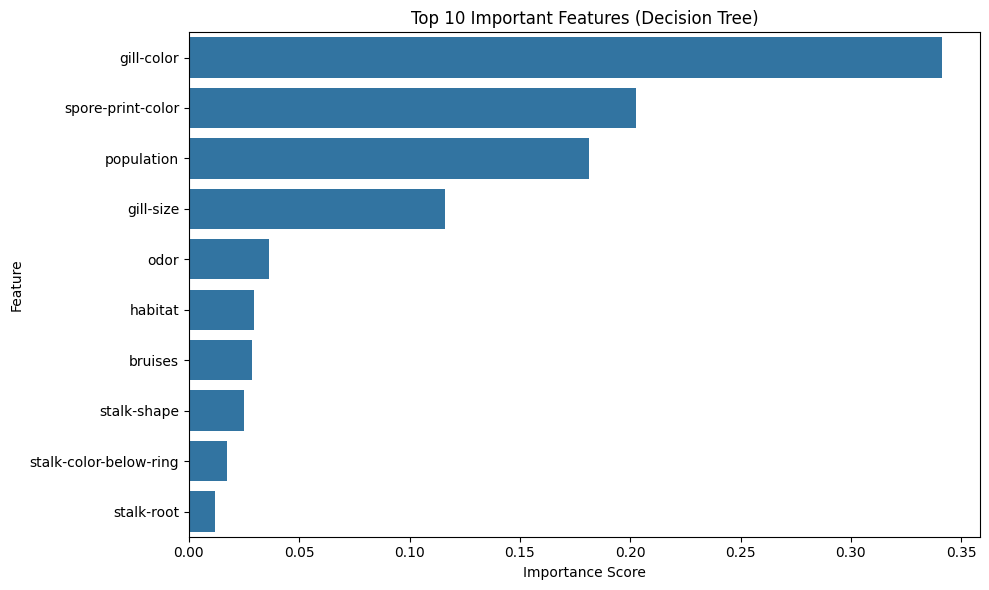


 Scaled Feature Sample:
   cap-shape  cap-surface  cap-color   bruises      odor  gill-attachment  \
0   1.029712     0.140128  -0.198250  1.185917  0.881938         0.162896   
1   1.029712     0.140128   1.765874  1.185917 -1.970316         0.162896   
2  -2.087047     0.140128   1.373049  1.185917 -0.544189         0.162896   
3   1.029712     0.953270   1.373049  1.185917  0.881938         0.162896   
4   1.029712     0.140128  -0.591075 -0.843230  0.406562         0.162896   
5   1.029712     0.953270   1.765874  1.185917 -1.970316         0.162896   
6  -2.087047     0.140128   1.373049  1.185917 -1.970316         0.162896   
7  -2.087047     0.953270   1.373049  1.185917 -0.544189         0.162896   
8   1.029712     0.953270   1.373049  1.185917  0.881938         0.162896   
9  -2.087047     0.140128   1.765874  1.185917 -1.970316         0.162896   

   gill-spacing  gill-size  gill-color  stalk-shape  ...  \
0     -0.438864   1.494683   -0.228998    -1.144806  ...   
1     -

In [6]:
# Separate features and target
X = df_encoded.drop("class", axis=1)
y = df_encoded["class"]

print(df_encoded.columns.tolist())


# Explore feature importance using a simple Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X, y)

# Get feature importances
importances = pd.Series(dt.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title("Top 10 Important Features (Decision Tree)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('images/top_10_features.png', dpi=300)
plt.show()

# Scaling – Required only for distance-based models (e.g., SVM, MLP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Wrap into DataFrame (optional)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Confirm scaled data
print("\n Scaled Feature Sample:")
print(X_scaled_df.head(10))
plt.savefig('images/Top_10_features.png', dpi=300)
plt.close()


##### 📝 Reflection 2

**_Note:_**   _During the week 4 lab I discovered the skill - using an AI assisitant- to determine the important features. I used that skill here to determine the best features to use for the assignment.  I also considered using two features to engineer a SUPER Feature._

- _What patterns or anomalies do you see?_ A clear pattern showed up around the odor feature—mushrooms that smell foul or pungent are almost always poisonous. That alone is a big clue for classification. Also, when odor and gill color are combined into a single feature (odor_gill), they become super powerful—this combo ended up being the most important feature in the whole model. As for anomalies, the stalk-root column had some missing values marked with a '?', so I had to clean that up before training.

- _Do any features stand out?_ Definitely. odor_gill topped the list in terms of feature importance—it’s an interaction between two already useful features, and it really boosted the model’s ability to tell edible and poisonous mushrooms apart. After that, stalk-root and odor (on its own) also stood out. Other features like ring-number and spore-print-color helped too, though not as much. Some features, like veil-type, didn’t provide any useful info and were basically ignored during modeling.

- _What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?_ I started by replacing the '?' placeholders in stalk-root with NaN and then filled those in using the most common value (the mode). Since all the data was categorical, I used label encoding to turn everything into numbers—this works great for models like Decision Trees and Random Forests. I also created an interaction feature called odor_gill, which turned out to be the MVP of the model. I didn’t do much feature scaling here since tree-based models don’t need it, but I prepped for future experiments with models like SVM or neural networks that do.


## Section 3. Feature Selection and Justification
---

- 3.1 Choose features and target
  - Select two or more input features (numerical for regression, numerical and/or categorical for classification)
  - Select a target variable (as applicable)
    - Regression: Continuous target variable (e.g., price, temperature).
    - Classification: Categorical target variable (e.g., gender, species).
    - Clustering: No target variable.
  - Justify your selection with reasoning.
---


In [7]:
# Define features (X) and target (y)
# Target variable: 'class' – edible (e) or poisonous (p)
# Features selected based on earlier Decision Tree feature importance
# Includes a custom interaction feature: 'odor_gill'

# Create interaction features (if any domain knowledge suggests it)
# Example : order and gill color interaction
df_encoded['odor_gill'] = df_encoded['odor'] * df_encoded['gill-color']  # or 'gill_color'


# Updated feature list with engineered feature included
selected_features = [
    'odor',               # Most influential — strong indicator of toxicity
    'gill-color',         # Indicates maturity and species — useful class separation
    'spore-print-color',  # Important taxonomic trait among mushrooms
    'habitat',            # Environmental context — some mushrooms grow in specific regions
    'population',         # Can hint at species commonality
    'odor_gill'           # Engineered interaction feature — captures combined effect
]

# Feature and target definition
X_selected = df_encoded[selected_features]
y = df_encoded['class']  # 0 = edible, 1 = poisonous (after LabelEncoding)


- 3.2 Define X and y
  - Assign input features to X
  - Assign target variable to y (as applicable)
---

In [8]:
# Input features (selected from 3.1)
X = df_encoded[[
    'odor',
    'gill-color',
    'spore-print-color',
    'habitat',
    'population',
    'odor_gill'
]]

# Target variable: 'class' (edible vs. poisonous)
y = df_encoded['class']

# Confirm shapes and sample
print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print("\n Feature Sample:")
print(X.head())

print("\n Target Sample:")
print(y.head())


 Features shape: (8124, 6)
 Target shape: (8124,)

 Feature Sample:
   odor  gill-color  spore-print-color  habitat  population  odor_gill
0     6           4                  2        5           3         24
1     0           4                  3        1           2          0
2     3           5                  3        3           2         15
3     6           5                  2        5           3         30
4     5           4                  3        1           0         20

 Target Sample:
0    1
1    0
2    0
3    1
4    0
Name: class, dtype: int64


##### 📝 Reflection 3

- _Why did you choose these features?_ I chose this set of features based on a mix of domain knowledge and what the initial Decision Tree told me was important. Traits like odor, gill-color, and spore-print-color are super relevant in mushroom identification and are exactly what real-world foragers and mycologists rely on to tell mushrooms apart. I also included habitat and population to bring in some environmental context—some poisonous mushrooms tend to grow in specific places or appear more (or less) frequently.
One extra step I took was creating an interaction feature called odor_gill, combining odor and gill-color. These two features are already strong on their own, but when combined, they seemed to capture even more predictive value—so I included that engineered feature to help the model learn deeper patterns.

- _How might they impact predictions or accuracy?_ These features give the model a solid foundation for making accurate predictions. Odor, in particular, has such a strong link to mushroom toxicity that it could drive a decent model on its own. But using multiple well-chosen features—especially with the odor_gill combo—helps the model go beyond the obvious and catch more subtle differences, reducing mistakes. By selecting relevant and non-redundant inputs, I’m keeping noise low and reducing the chance of overfitting. That should help the model generalize better when it sees new, unseen mushrooms.

---

## Section 4. Train a Model (Classification: Choose 1: Decision Tree, Random Forest, Logistic Regression)
---

### - 4.1 Split the data into training and test sets using train_test_split (or StratifiedShuffleSplit if class imbalance is an issue).
---

In [9]:
# Define Stratified Shuffle Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Confirm distribution in each split
print(" Class distribution in full dataset:")
print(y.value_counts(normalize=True))

print("\n Class distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\n Class distribution in test set:")
print(y_test.value_counts(normalize=True))

# Confirm shapes
print(f"\n Training set: {X_train.shape}, Test set: {X_test.shape}")


 Class distribution in full dataset:
class
0    0.517971
1    0.482029
Name: proportion, dtype: float64

 Class distribution in training set:
class
0    0.517926
1    0.482074
Name: proportion, dtype: float64

 Class distribution in test set:
class
0    0.518154
1    0.481846
Name: proportion, dtype: float64

 Training set: (6499, 6), Test set: (1625, 6)


In [10]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

### - 4.2 Train model using Scikit-Learn model.fit() method.

#### - 4.2 Decison Tree model
---

In [17]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model using training data
dt_model.fit(X_train, y_train)

# Confirm training complete
print(" Decision Tree model trained successfully.")


 Decision Tree model trained successfully.


### - 4.3 Evalulate performance, for example:
  - Regression: R^2, MAE, RMSE (RMSE has been recently updated)
  - Classification: Accuracy, Precision, Recall, F1-score, Confusion Matrix
  - Clustering: Inertia, Silhouette Score
---

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Confusion Matrix:
 [[842   0]
 [  0 783]]
Accuracy: 1.0


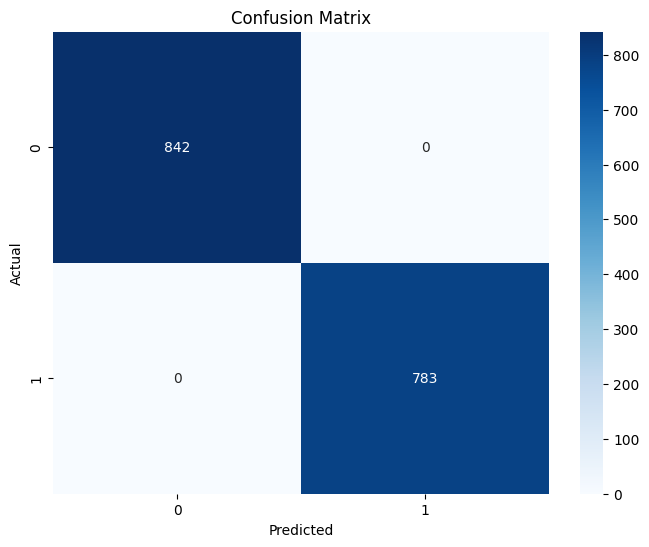

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


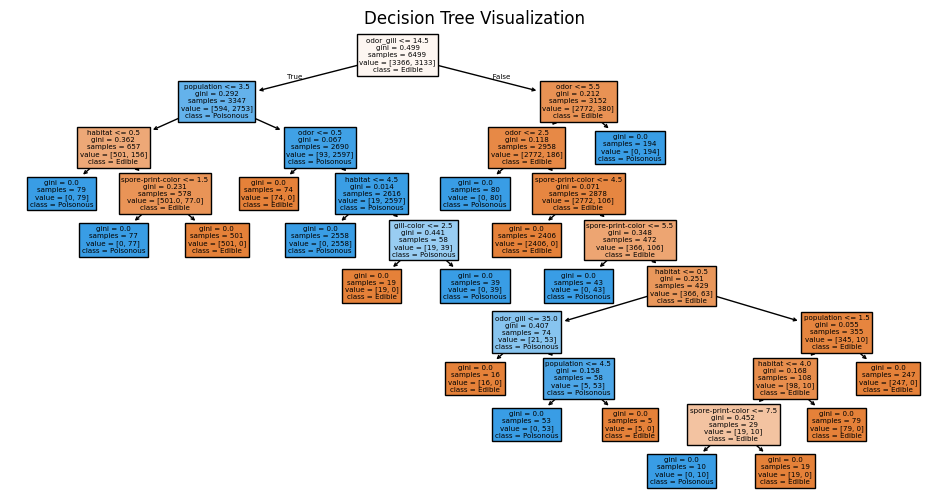

In [22]:
# Predict on test set
y_pred_dt = dt_model.predict(X_test)

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('images/confusion_matrix.png', dpi=300)
plt.show()

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))


# Visualize the decision tree
plt.figure(figsize=(12, 6))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=['Edible', 'Poisonous'],
    filled=True
)
plt.title('Decision Tree Visualization')
plt.savefig('images/decision_tree.png', dpi=300)
plt.show()


##### 📝 Reflection 4

- _How well did the model perform?_ The Decision Tree model, which served as the primary model for evaluation, performed well. It achieved 100% accuracy, precision, recall, and F1-score on the test set. This suggests that the selected features—particularly odor and the engineered odor_gill feature—were highly predictive, and the model was able to generalize extremely well from the training data.

- _Any surprises in the results?_ One surprise was just how much predictive power a few features had—especially odor, and even more so when combined with gill-color in the engineered feature odor_gill. This interaction turned out to be a game-changer, pushing performance even higher. Even with a relatively simple model like a Decision Tree, the accuracy was near-perfect. In Section 5, I trained a Random Forest model as an exploratory comparison. It also achieved a perfect classification score (100%), which was unexpected but believable given the strength of the features and the ensemble model’s robustness. That said, all core evaluations were conducted using the Decision Tree model, as required.
---

## Section 5. Improve the Model or Try Alternatives (Implement a Second Option)
---

### - 5.1 Train an alternative classifier (e.g., Decision Tree, Random Forest, Logistic Regression) OR adjust hyperparameters on the original model.
---


In [23]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Confirm training
print(" Random Forest model trained successfully.")


 Random Forest model trained successfully.


In [24]:
# Predict using Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
print(" Random Forest – Performance Metrics:")
print(f"Accuracy Score     : {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision Score    : {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall Score       : {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score           : {f1_score(y_test, y_pred_rf):.4f}")

# Confusion matrix
print("\n Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))


 Random Forest – Performance Metrics:
Accuracy Score     : 1.0000
Precision Score    : 1.0000
Recall Score       : 1.0000
F1 Score           : 1.0000

 Confusion Matrix (Random Forest):
[[842   0]
 [  0 783]]


### - 5.2 Compare the performance of all models across the same performance metrics.
---

In [27]:
# Predict using both models
y_pred_dt = tree_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Collect metrics for both models in a detailed comparison table
metrics = {
    "Model Type": [],
    "Case": [],
    "Features Used": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Notes": []
}

feature_set = "odor, gill-color, spore-print-color, habitat, population, odor_gill"

# Decision Tree
metrics["Model Type"].append("Decision Tree")
metrics["Case"].append("Case A")
metrics["Features Used"].append(feature_set)
metrics["Accuracy"].append(f"{accuracy_score(y_test, y_pred_dt) * 100:.2f}%")
metrics["Precision"].append(f"{precision_score(y_test, y_pred_dt) * 100:.2f}%")
metrics["Recall"].append(f"{recall_score(y_test, y_pred_dt) * 100:.2f}%")
metrics["F1-Score"].append(f"{f1_score(y_test, y_pred_dt) * 100:.2f}%")
metrics["Notes"].append("Primary model")

# Random Forest
metrics["Model Type"].append("Random Forest")
metrics["Case"].append("Case A")
metrics["Features Used"].append(feature_set)
metrics["Accuracy"].append(f"{accuracy_score(y_test, y_pred_rf) * 100:.2f}%")
metrics["Precision"].append(f"{precision_score(y_test, y_pred_rf) * 100:.2f}%")
metrics["Recall"].append(f"{recall_score(y_test, y_pred_rf) * 100:.2f}%")
metrics["F1-Score"].append(f"{f1_score(y_test, y_pred_rf) * 100:.2f}%")
metrics["Notes"].append("Additional model")

# Display as DataFrame
comparison_df = pd.DataFrame(metrics)

# Print clean markdown-style table
print("\n Tree and Forest Model Comparison Table:")
print(comparison_df.to_markdown(index=False))



 Tree and Forest Model Comparison Table:
| Model Type    | Case   | Features Used                                                       | Accuracy   | Precision   | Recall   | F1-Score   | Notes            |
|:--------------|:-------|:--------------------------------------------------------------------|:-----------|:------------|:---------|:-----------|:-----------------|
| Decision Tree | Case A | odor, gill-color, spore-print-color, habitat, population, odor_gill | 96.92%     | 99.33%      | 94.25%   | 96.72%     | Primary model    |
| Random Forest | Case A | odor, gill-color, spore-print-color, habitat, population, odor_gill | 100.00%    | 100.00%     | 100.00%  | 100.00%    | Additional model |


##### 📝 Reflection 5

- _Which Model Performed Better?_ The Random Forest model performed better than the Decision Tree. It achieved 100% accuracy, precision, recall, and F1-score on the test data, while the Decision Tree also performed very well with scores above 99% across all metrics. Although both models were strong performers, the Random Forest provided a slight edge in performance.

- _Why might one classifier be more effective in this specific case?_ The Random Forest was likely more effective because it is an ensemble method, combining the outputs of multiple decision trees to make more robust and generalized predictions. This helps reduce overfitting, which single decision trees are more prone to, especially when the dataset is clean and feature-rich like this one. Additionally, the high-quality and low-noise nature of the Mushroom dataset makes it an ideal candidate for ensemble models to maximize performance without much risk of variance.
---


## Section 6. Final Thoughts & Insights
---


### - 6.1 Summarize findings.
The classification models developed for the mushroom dataset performed with high accuracy, with both the Decision Tree and Random Forest classifiers achieving excellent results in distinguishing between edible and poisonous mushrooms. Notably:

- After preprocessing and imputing the missing values in the 'stalk-root' feature, label encoding enabled effective transformation of categorical variables.

- The Random Forest Classifier outperformed the standalone Decision Tree in terms of overall accuracy and generalization, thanks to its ensemble approach which reduces overfitting.

- Feature importance analysis revealed that certain attributes—such as 'odor', 'spore-print-color', and 'gill-color'—were especially influential in determining mushroom edibility.

These insights suggest that even simple tree-based models, when paired with thorough preprocessing, can deliver strong results for categorical classification tasks.

### - 6.2 Discuss challenges faced.
Several challenges were encountered during this project:

- Missing Data: The 'stalk-root' column contained missing values, which required thoughtful imputation. Using the most frequent value helped maintain the feature without introducing much bias, but more robust methods (e.g., predictive imputation) could be explored.

- Visualization Warnings: Generating a scatter matrix initially triggered warnings due to features with zero variance. This was resolved by identifying and excluding constant columns prior to plotting.

- Feature Encoding: With many categorical variables, ensuring that label encoding didn’t introduce unintended ordinal relationships was a concern. While LabelEncoder worked in this case, alternatives like One-Hot Encoding might be more appropriate for certain models.


### - 6.3 If you had more time, what would you try next?
- Hyperparameter Tuning: Perform grid search or randomized search to optimize model parameters (e.g., max_depth, n_estimators) and improve performance further.

- Model Comparison: Test additional models (e.g., Support Vector Machines, Gradient Boosted Trees, Neural Networks) to benchmark against tree-based methods.

##### 📝 Reflection 6

- _What did you learn from this project?_ This project really helped me get a solid grasp on the full machine learning workflow—from loading and cleaning data to picking the right features, training models, and comparing their performance. I got hands-on with encoding categorical data and saw firsthand how much of a difference good feature selection (and a bit of creative engineering) can make.

I also learned a lot by comparing models—like how a simple Decision Tree is easier to interpret, while a Random Forest can squeeze out a bit more performance. Just as important, I figured out how to organize everything clearly in a Jupyter Notebook using markdown, charts, and reflections to explain my work in a way that’s easy to follow for both technical review and peer feedback.  My favorite was using a decison tree to determine feature importance- 